# STM Transit Delay Data Modeling

This notebook explores three tree-based regression models in order to find the one that predicts the delay with the best accuracy.

## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from xgboost import XGBRegressor

In [3]:
df = pd.read_csv('../data/preprocessed.csv')

## Split the data

In [4]:
# Separate the features from the target variable
X = df.drop('delay', axis=1)
y = df['delay']

In [5]:
# Train-validation-test split (70-15-15) 
# Use 70% for training because the dataset is large
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Since only tree-based regression models are explored in this project, scaling is not needed because the models are not sensitive to the absolute scale or distribution of the features.

## Base Model: Random Forest Regression

### Fit Model

In [6]:
base_model = RandomForestRegressor(n_estimators=5, random_state=42)
base_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=5, random_state=42)

In [7]:
y_pred = base_model.predict(X_val)

### Evaluate Model

#### Metrics

In [8]:
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

In [9]:
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

MAE: 75.80
MSE: 17405.11
RMSE: 131.93
R²: 0.1186


**MAE**<br>
On average, the predictions are off by one minute, which seems reasonable.

**RMSE**<br>
The typical error being about 2 minutes seems pretty good.

**R²**<br>
The model explains 48% of the variance in the actual delays, which is not too bad, considering how noisy and random transit delays can be (weather, mechanical issues, accidents, etc.)

#### Residual Analysis

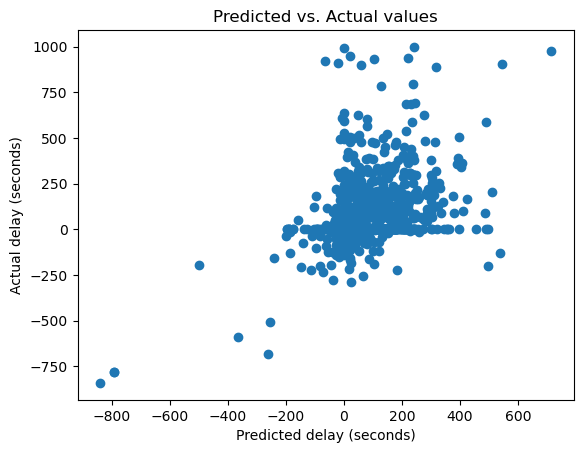

In [10]:
# Plot predicted vs. actual values
plt.scatter(x=y_pred, y=y_val)
plt.title('Predicted vs. Actual values')
plt.xlabel('Predicted delay (seconds)')
plt.ylabel('Actual delay (seconds)')
plt.savefig('../images/actual_vs_predict_base.png', bbox_inches='tight')
plt.show()

Interpret plot

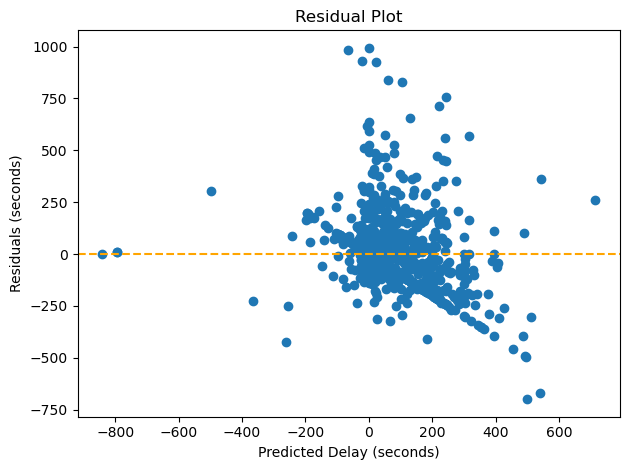

In [11]:
# Plot residuals
residuals = y_val - y_pred
    
plt.scatter(x=y_pred, y=residuals)
plt.title('Residual Plot')
plt.xlabel('Predicted Delay (seconds)')
plt.ylabel('Residuals (seconds)')
plt.axhline(0, linestyle='--', color='orange')
plt.tight_layout()
plt.savefig('../images/residual_plot_base.png', bbox_inches='tight')
plt.show()

Interpret plot

#### K-Fold Cross Validation

In [12]:
scoring = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'R²': make_scorer(r2_score)
}

scores = cross_validate(
  base_model,
  X_train,
  y_train,
  scoring=scoring,
  cv=5,
  n_jobs=-1)

scores_df = pd.DataFrame(scores)

In [13]:
scores_df

,fit_time,score_time,test_MAE,test_MSE,test_R²
0,0.743231,0.013554,-71.986290,-15117.900517,0.112694
1,0.741216,0.010669,-74.095370,-17130.298232,-0.023146
2,0.735267,0.012520,-75.053037,-16363.194227,0.055515
3,0.738365,0.011085,-71.843803,-17046.804765,-0.005458
4,0.735812,0.011945,-71.037304,-15532.542960,0.084595


In [14]:
print(f'Mean MAE: {-scores_df['test_MAE'].mean()}')
print(f'Mean MSE: {-scores_df['test_MSE'].mean()}')
print(f'Mean RMSE: {np.sqrt(-scores_df['test_MSE']).mean()}')
print(f'Mean R²: {scores_df['test_R²'].mean()}')

Mean MAE: 72.80316068636198
Mean MSE: 16238.148140436033
Mean RMSE: 127.38987493287364
Mean R²: 0.04484000394688146


### Hyperparameter tuning

In [ ]:
# Run a grid search
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10, 15],
    'max_features': ['sqrt', 'log2', None]
}

search_model = GridSearchCV(
  estimator=RandomForestRegressor(),
  param_grid=param_grid,
  scoring='neg_min_squared_error',
  cv=None)

search_model.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10, 20, 30, 40, None],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_split': [2, 5, 10, 15],
                         'n_estimators': [10, 20, 50, 100]},
             refit='MSE',
             scoring={'MAE': make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'),
                      'MSE': make_scorer(mean_squared_error, greater_is_better=False, response_method='predict'),
                      'R²': make_scorer(r2_score, response_method='predict')})

In [19]:
search_model.best_params_

{'max_depth': 40,
 'max_features': 'log2',
 'min_samples_split': 5,
 'n_estimators': 100}

In [ ]:
# Fit model with best parameters

In [ ]:
# Calculate metrics

In [ ]:
# Plot residuals

In [ ]:
# Run Cross Validation

### Feature importances

In [29]:
importances = base_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in base_model.estimators_], axis=0)

In [ ]:
# Sort predictors
forest_importances = pd.Series(importances, index=X.columns)
forest_importances.sort_values(ascending=False)

historical_avg_delay    0.282067
delay_was_clipped       0.244903
trip_progress_pct       0.101017
stop_sequence           0.086540
pca_coords              0.049333
stop_id                 0.043766
route_id                0.042393
windspeed               0.024494
temperature             0.023330
sch_hour_sin            0.022138
dtype: float64

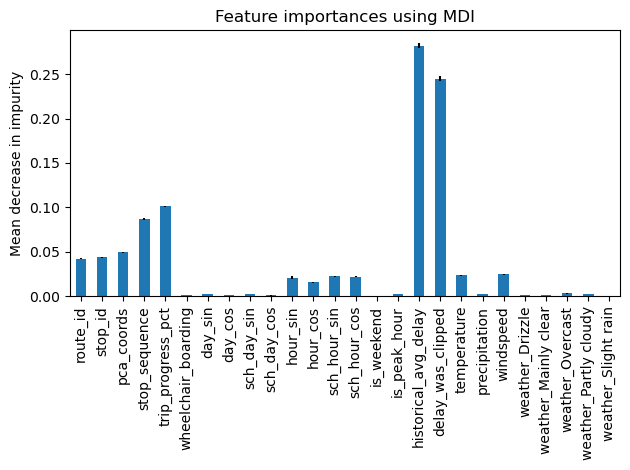

In [32]:
# Plot the impurity-based importance (MDI)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title('Feature importances using MDI')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()
plt.savefig('../images/mdi_base.png', bbox_inches='tight')
plt.show()

Interpret plot

## Model ensembling: Random Forest + Gradient Boosting

## XGBoost

## Final Model

### Evaluation

### Make Prediction

## End